In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
import json
import csv

In [16]:
N_WAVELENGTH = 228
LOD_URE = 1000

In [25]:
df = pd.read_csv("C:\Users\\truon\OneDrive\Documents\Bach khoa\Capstone Project\NIR_code\data_NIRS\Merged_db.csv")
df = df.drop_duplicates()
df_copy = df.copy()
df.head()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2999657571.py, line 1)

# Xử lý dữ liệu NaN và vô hạn

In [ ]:
print(f'Tổng các điểm dữ liệu trống trước xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn trước xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống trước xử lý: 0
Tổng các điểm dữ liệu vô hạn trước xử lý: 0


In [ ]:
# Lấy tất cả vị trí của các trị trống hoặc vô hạn
null_check = df.isna()
indices_null = np.argwhere(null_check.to_numpy() == True)

df_inf = df.iloc[:,-N_WAVELENGTH:]
inf_check = np.isinf(df_inf)
indices_inf = np.argwhere(inf_check.to_numpy()== True)
indices_inf[:,1] += df.shape[1] - N_WAVELENGTH

indices = np.concatenate((indices_inf, indices_null))

In [ ]:
n_nearest = 2 # Sử dụng n giá trị gần nhất cả 2 phía trước và sau để tính mean của missing data
for x,y in indices:
    if y < df.shape[1] - N_WAVELENGTH: # Chỉ xử lý các missing data của phổ
        continue
    #sample = df.iloc[x, np.maximum(y - n_nearest , 0):np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    left = df.iloc[x,  np.maximum(y - n_nearest , 0) : y]
    right = df.iloc[x, y + 1 : np.minimum(y + 1 + n_nearest, df.shape[1]-1)]
    sample = left.combine_first(right)
    df.iloc[x, y] = np.mean(sample)


In [ ]:
print(f'Tổng các điểm dữ liệu trống sau xử lý: {df.iloc[:,-N_WAVELENGTH:].isna().sum().sum()}')
print(f'Tổng các điểm dữ liệu vô hạn sau xử lý: {np.isinf(df.iloc[:,-N_WAVELENGTH:]).sum().sum()}')

Tổng các điểm dữ liệu trống sau xử lý: 0
Tổng các điểm dữ liệu vô hạn sau xử lý: 0


# Thống kê dữ liệu

In [ ]:
df_copy.columns[:20]

Index(['Mã NIR', 'Urea', 'Nhóm đo', 'Chỉ tiêu đo', 'Loại cá',
       'Địa điểm lấy mẫu', 'STT mẫu cá', 'Vị trí đo', 'Lần lặp',
       'Phương pháp đo', 'Ngày giờ đo', 'Mã thiết bị đo', '12', '13', '14',
       '15', '16', '17', '18', '19'],
      dtype='object')

In [ ]:
df_copy.reset_index()

,index,Mã NIR,Urea,Nhóm đo,Chỉ tiêu đo,Loại cá,Địa điểm lấy mẫu,STT mẫu cá,Vị trí đo,Lần lặp,...,230,231,232,233,234,235,236,237,238,239
0,0,2113099a1,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",1,...,-0.136101,-0.287185,-0.380416,-0.459176,-0.407652,-0.472400,-0.429911,-0.333819,-0.395731,-0.167501
1,1,2113099a2,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",2,...,-0.135012,-0.306666,-0.467668,-0.492477,-0.481871,-0.370628,-0.297349,-0.409274,-0.486664,-0.426964
2,2,2113099a3,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",3,...,-0.324308,-0.427586,-0.539696,-0.547557,-0.575114,-0.555003,-0.462344,-0.440240,-0.298107,-0.313747
3,3,2113099a4,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",4,...,-0.298622,-0.377505,-0.534373,-0.577949,-0.533663,-0.570596,-0.488621,-0.419825,-0.354021,-0.295377
4,4,2113099a5,19147.4,Đà Nẵng,Ure,Nục 1,Cảng cá,99,"Ngoài da, gáy",5,...,-0.272732,-0.429970,-0.496265,-0.559068,-0.586745,-0.516311,-0.469121,-0.351306,-0.360435,-0.257529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8445,9945,2133265l1,473.4,Đà Nẵng,Ure,Ngừ 1,Cảng cá,265,"Trong thịt, bụng",1,...,0.523200,0.358913,0.390836,0.370825,0.306330,0.365942,0.231241,0.057702,0.584293,0.398784
8446,9946,2133265l2,473.4,Đà Nẵng,Ure,Ngừ 1,Cảng cá,265,"Trong thịt, bụng",2,...,0.611741,0.602811,0.560084,0.306237,0.349762,0.185321,0.453802,0.143648,0.395798,0.965556
8447,9947,2133265l3,473.4,Đà Nẵng,Ure,Ngừ 1,Cảng cá,265,"Trong thịt, bụng",3,...,0.547452,0.421365,0.518515,0.160644,0.338064,0.291017,0.503532,0.418252,0.065953,0.321586
8448,9948,2133265l4,473.4,Đà Nẵng,Ure,Ngừ 1,Cảng cá,265,"Trong thịt, bụng",4,...,0.389884,0.302312,0.312166,0.424677,0.109803,0.225650,0.300984,0.027399,0.448596,0.090152


In [ ]:
df.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949],
      dtype='int64', length=8450)

In [ ]:
df_copy.columns[:20]

Index(['Mã NIR', 'Urea', 'Nhóm đo', 'Chỉ tiêu đo', 'Loại cá',
       'Địa điểm lấy mẫu', 'STT mẫu cá', 'Vị trí đo', 'Lần lặp',
       'Phương pháp đo', 'Ngày giờ đo', 'Mã thiết bị đo', '12', '13', '14',
       '15', '16', '17', '18', '19'],
      dtype='object')

In [ ]:
from collections import namedtuple
import json

configJsonLink = './config.json'
config = json.load(open(configJsonLink, encoding="utf8"))
config = namedtuple("ObjectName", config.keys())(*config.values())

nirsMetadataCoding = json.load(open(config.nirsMetadataCodingFileName, encoding="utf8"))
nirsMetadataCoding = namedtuple("ObjectName", nirsMetadataCoding.keys())(*nirsMetadataCoding.values())

In [ ]:
for nirsIdComponent in config.nirsIdComponents:
    nirsMetadata = [data for data in nirsMetadataCoding.nirsIdComponents if data['name'] == nirsIdComponent['name']][0]

    for value in nirsMetadata['decode']:
        # print(value['key'])
        # if idMetadata == value['key']:
        #     fishData[nirsIdComponent['name']] = value['name']
        # fishData[nirsIdComponent['name']] = value['name']
        print(nirsIdComponent['name'], value['name'], value['key'])

Nhóm đo Hà Nội 1
Nhóm đo Đà Nẵng 2
Nhóm đo Sài Gòn 3
Chỉ tiêu đo Ure 1
Chỉ tiêu đo Histamine 2
Chỉ tiêu đo Hàn the 3
Chỉ tiêu đo Acid domoic 4
Chỉ tiêu đo Chỉ số K 5
Chỉ tiêu đo TBA 6
Chỉ tiêu đo TVB-N 7
Chỉ tiêu đo Tổng VSV 8
Loại cá Nục 1 1
Loại cá Nục 2 2
Loại cá Ngừ 1 3
Loại cá Ngừ 2 4
Loại cá Thu 1 5
Loại cá Thu 2 6
Địa điểm lấy mẫu Chợ 1
Địa điểm lấy mẫu Siêu thị 2
Địa điểm lấy mẫu Cảng cá 3
STT mẫu cá 1 1
STT mẫu cá 2 2
STT mẫu cá 3 3
STT mẫu cá 4 4
STT mẫu cá 5 5
STT mẫu cá 6 6
STT mẫu cá 7 7
STT mẫu cá 8 8
STT mẫu cá 9 9
STT mẫu cá 10 10
STT mẫu cá 11 11
STT mẫu cá 12 12
STT mẫu cá 13 13
STT mẫu cá 14 14
STT mẫu cá 15 15
STT mẫu cá 16 16
STT mẫu cá 17 17
STT mẫu cá 18 18
STT mẫu cá 19 19
STT mẫu cá 20 20
STT mẫu cá 21 21
STT mẫu cá 22 22
STT mẫu cá 23 23
STT mẫu cá 24 24
STT mẫu cá 25 25
STT mẫu cá 26 26
STT mẫu cá 27 27
STT mẫu cá 28 28
STT mẫu cá 29 29
STT mẫu cá 30 30
STT mẫu cá 31 31
STT mẫu cá 32 32
STT mẫu cá 33 33
STT mẫu cá 34 34
STT mẫu cá 35 35
STT mẫu cá 36 36
STT m

In [ ]:
nirsMetadataCoding = json.load(open('a.json', encoding="utf8"))

In [3]:
'111111'.zfill(5)

'111111'

In [ ]:
nirsMetadataCoding['Loại cá']['name']

KeyError: 'name'

In [14]:

import re

for i in df_copy.index:
    if not bool(re.search(r'[a-z]',df_copy['Mã NIR'][i])):
        #df_copy = df2.drop(index=i)
        nhom_do = df_copy['Nhóm đo'][i]
        chi_tieu_do = df_copy['Chỉ tiêu đo'][i]
        STT_mau_ca = df_copy['STT mẫu cá'][i]
        dia_diem_lay_mau = df_copy['Địa điểm lấy mẫu'][i]
        loai_ca = df_copy['Loại cá'][i]
        vi_tri_do = df_copy['Vị trí đo'][i]
        lan_lap = df_copy['Lần lặp'][i]
        # print(df_copy['Mã NIR'][i], df_copy['Nhóm đo'][i], df_copy['Chỉ tiêu đo'][i], df_copy['Loại cá'][i], df_copy['Địa điểm lấy mẫu'][i], df_copy['STT mẫu cá'][i], df_copy['Vị trí đo'][i], df_copy['Lần lặp'][i])

        for nirsIdComponent in config.nirsIdComponents:
            nirsMetadata = [data for data in nirsMetadataCoding.nirsIdComponents if data['name'] == nirsIdComponent['name']][0]

            for value in nirsMetadata['decode']:
                # print(value['key'])
                # if idMetadata == value['key']:
                #     fishData[nirsIdComponent['name']] = value['name']
                # fishData[nirsIdComponent['name']] = value['name']
                print(nirsIdComponent['name'], value['name'], value['key'])
        
        

NameError: name 'df_copy' is not defined

In [ ]:
for x in df['STT mẫu cá'].value_counts().keys():
    print(x)

In [25]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df, df['STT mẫu cá'], stratify=df['STT mẫu cá'], test_size=0.2, random_state=42)


STT mẫu cá
472    52
385    48
558    48
475    48
261    48
       ..
390    48
380    48
462    48
481    48
560    36
Name: count, Length: 141, dtype: int64

In [19]:

X = df.iloc[:,-N_WAVELENGTH:]
Y = df.iloc[:,1]
y_labels = np.where(Y >= LOD_URE, 1, 0)


In [20]:
label_value = np.unique(y_labels, return_counts = True)
label_value

(array([0, 1]), array([6350, 2100], dtype=int64))

Text(0.5, 1.0, 'Count of label')

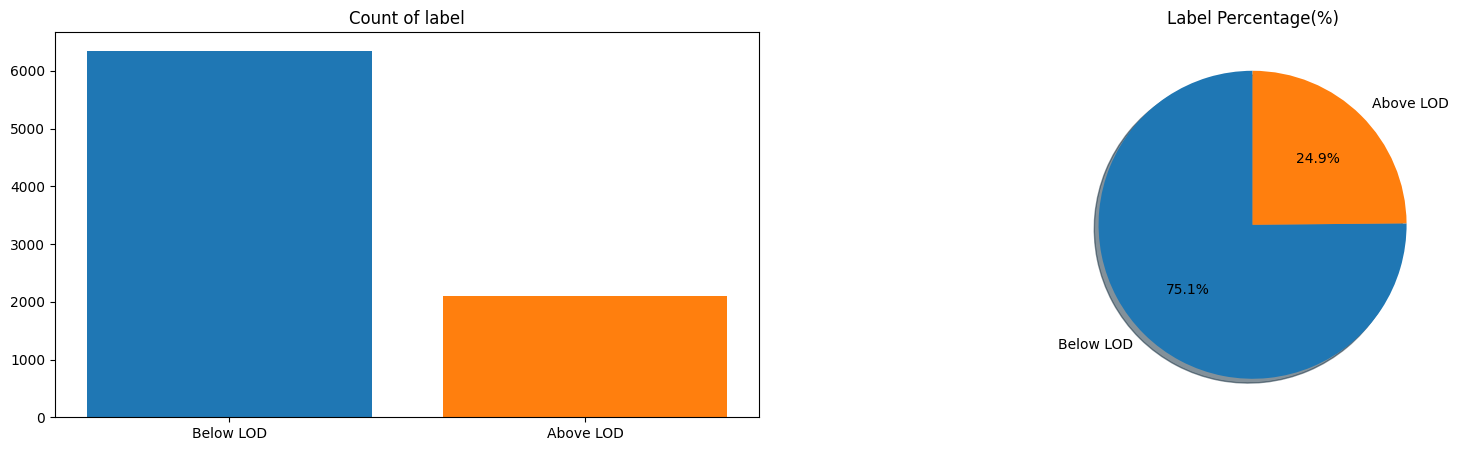

In [21]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

axes[1].pie(label_value[1], labels=['Below LOD', 'Above LOD'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%)')
axes[0].bar(label_value[0], label_value[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')

Xử lý dữ liệu imbalance với SMOTE

In [79]:
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()
X_smote, y_smote = over_sample.fit_resample(X, y_labels)

Text(0.5, 1.0, 'Count of label')

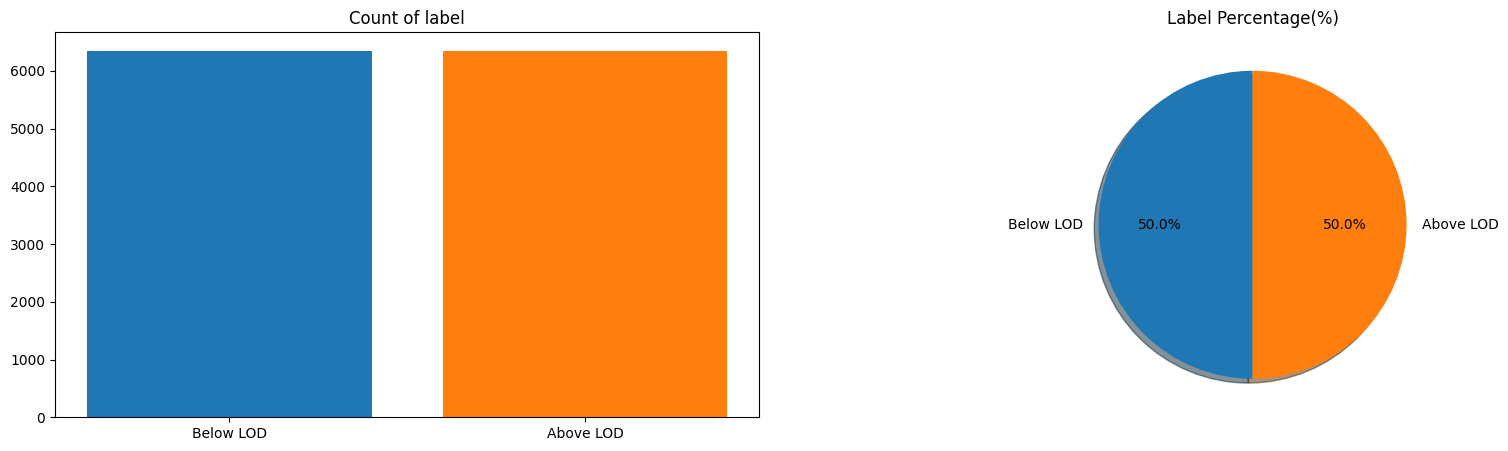

In [80]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

label_value_smote = np.unique(y_smote, return_counts = True)
axes[1].pie(label_value_smote[1], labels=['Below LOD', 'Above LOD'], autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].set_title('Label Percentage(%)')
axes[0].bar(label_value_smote[0], label_value_smote[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')

Text(0.5, 1.0, 'Count of label')

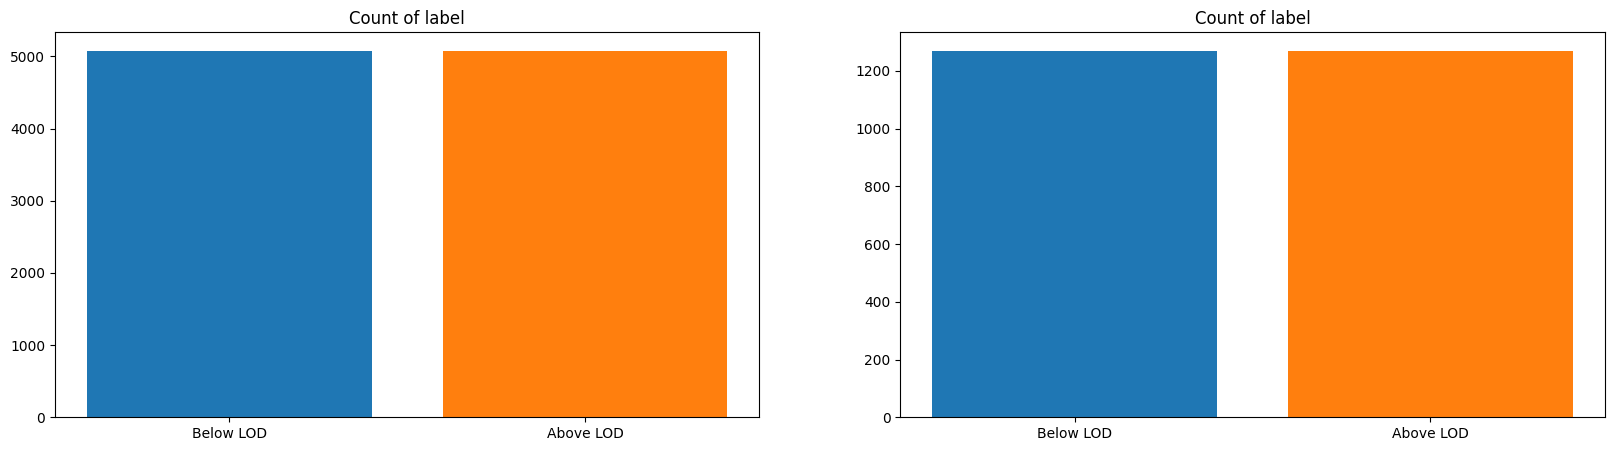

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, stratify=y_smote, test_size=0.2, random_state=42)

y_train_value = np.unique(y_train, return_counts = True)
y_test_value = np.unique(y_test, return_counts = True)
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

axes[0].bar(y_train_value[0], y_train_value[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[0].set_title('Count of label')
axes[1].bar(y_test_value[0], y_test_value[1], tick_label=['Below LOD', 'Above LOD'], align='center', color=sns.color_palette())
axes[1].set_title('Count of label')

# Tiền xử lý

MSC - Multiplicative Scatter Correction

Savizky-Golay 

In [82]:
def my_SG(X, deriv=0):
    return savgol_filter(X, window_length=25, polyorder=5, deriv=deriv)

# Normalization

In [83]:
def snv(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        temp_mean = temp_nir.mean()
        temp_std = temp_nir.std(ddof=0)
        df_output.iloc[i,-N_WAVELENGTH:] = (df_output.iloc[i,-N_WAVELENGTH:] - temp_mean) / temp_std
    return df_output

def msc(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    df_input = (df_input.T - np.mean(df_input.T, axis=0)).T
    # for i in range(df_input.shape[0]):
    #     df_input.iloc[i,:] -= df_input.iloc[i,:].mean()
 
    # Ước tính phổ tham chiếu (reference spectrum) = mean
    ref = np.mean(df_input, axis=0)

    for i in range(df_input.shape[0]):
        # Run regression
        fit = np.polyfit(ref, df_input.iloc[i,:], 1, full=True)
        # Apply correction
        df_output.iloc[i,-N_WAVELENGTH:] = (df_input.iloc[i,:] - fit[0][1]) / fit[0][0] 
    return df_output

def my_MinMaxScaler(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        x_min = min(df_output.iloc[i,-N_WAVELENGTH:])
        x_max = max(df_output.iloc[i,-N_WAVELENGTH:])
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - x_min) / (x_max - x_min)
    return df_output

def my_RobustScaler(df_input, N_WAVELENGTH=228):
    df_output = df_input.copy()
    for i in range(df_output.shape[0]):
        temp_nir = []
        temp_nir = df_output.iloc[i,-N_WAVELENGTH:].to_numpy()
        Q1 = np.percentile(temp_nir, 25)
        median = np.percentile(temp_nir, 50)
        Q3 = np.percentile(temp_nir, 75)
        df_output.iloc[i,-228:] = (df_output.iloc[i,-N_WAVELENGTH:] - median) / (Q3 - Q1)
    return df_output


# Visualization

Text(0.5, 1.0, 'Phổ của 5 khoảng thời gian đo của mẫu cá 041')

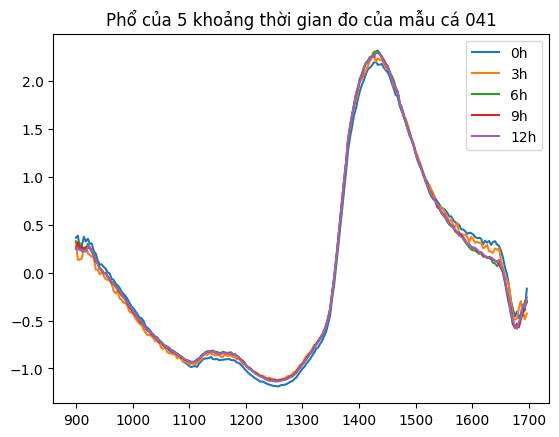

In [84]:
wl = np.arange(900, 1700, 800/228)
one_sample = df.iloc[0:5, -228:]
for i in range(5):
    plt.plot(wl, one_sample.iloc[i,:], label=f'{i*3}h')
plt.legend()
plt.title('Phổ của 5 khoảng thời gian đo của mẫu cá 041')

In [85]:
sample = []
for type in df['Loại cá'].unique():
    c = df[df['Loại cá'].str.contains(type)].reset_index()
    sample.append(c.iloc[0,-228:].to_numpy())
    
X_sample = pd.DataFrame(sample)
wl = np.arange(900, 1700, 800/228)

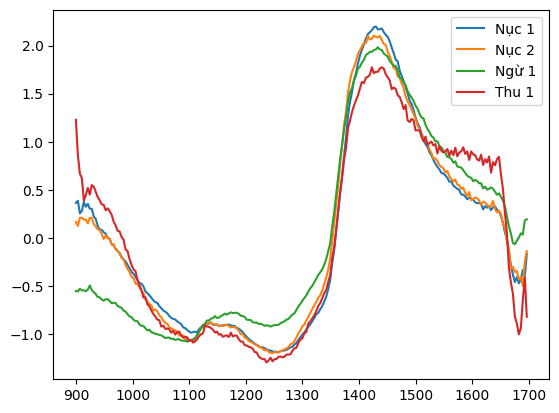

In [86]:
for i, type_fiss in enumerate(df['Loại cá'].unique()):
    plt.plot(wl, (X_sample).iloc[i,:], label=type_fiss)
plt.legend()

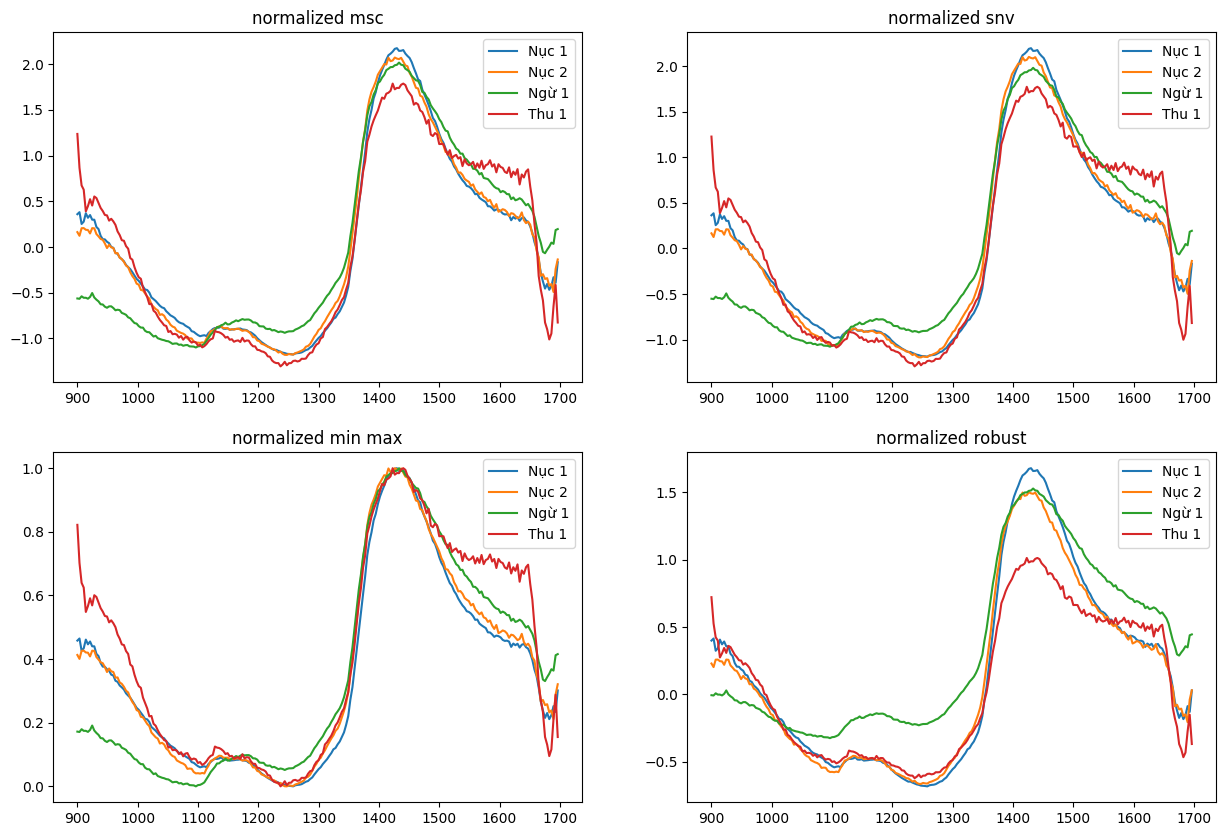

In [87]:
X_Robust = my_RobustScaler(X_sample)
X_minmax = my_MinMaxScaler(X_sample)
X_msc = msc(X_sample)
X_snv = snv(X_sample)

my_list = [X_msc, X_snv, X_minmax, X_Robust]
name = ['normalized msc', 'normalized snv', 'normalized min max', 'normalized robust']

fig, ax = plt.subplots(2, 2, figsize=(15,10))

i2 = 0
for a in range(2):
    for b in range(2):
        for i, type_fiss in enumerate(df['Loại cá'].unique()):
            ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
            ax[a][b].set_title(name[i2])
        ax[a][b].legend()
        i2 += 1

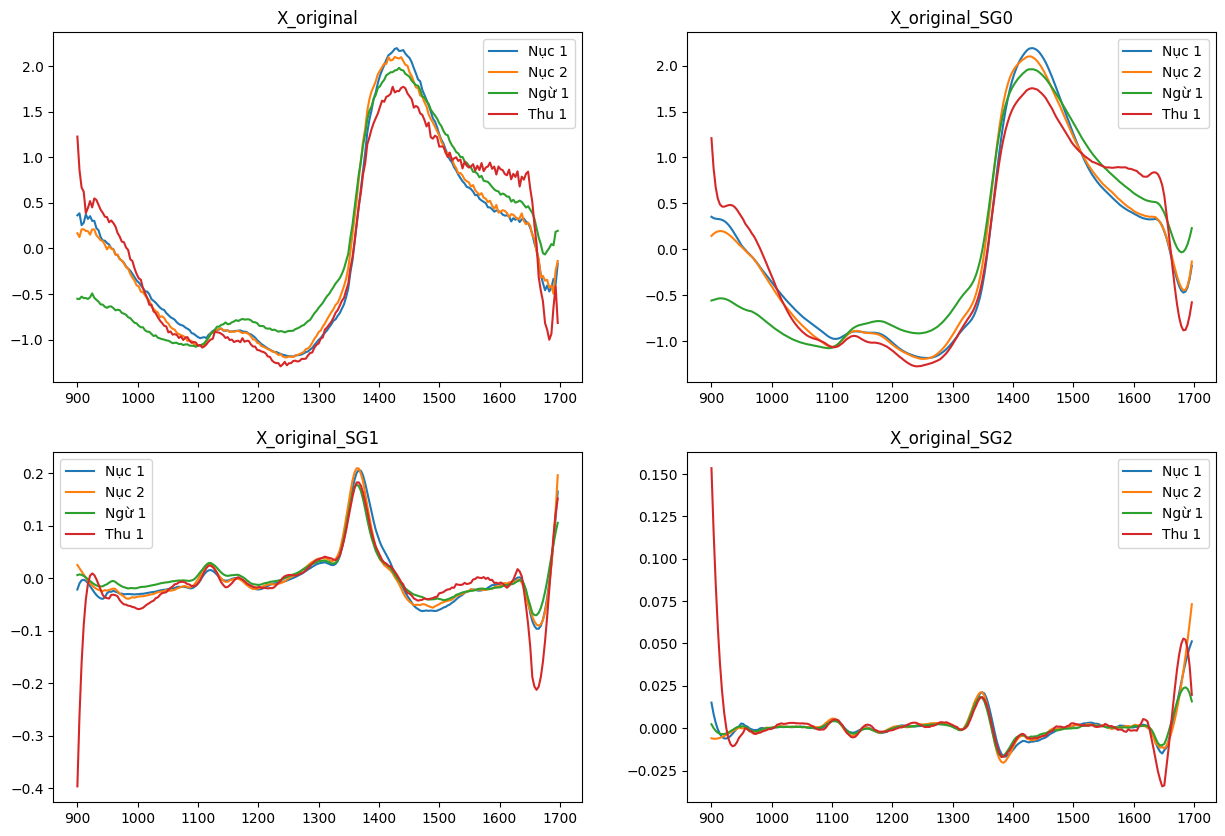

In [88]:
def plot_spectral(data, name_data):
    fig, ax = plt.subplots(2, 2, figsize=(15,10))

    X_SG0 = pd.DataFrame(my_SG(data, deriv=0))
    X_SG1 = pd.DataFrame(my_SG(data, deriv=1))
    X_SG2 = pd.DataFrame(my_SG(data, deriv=2))

    my_list = [data, X_SG0, X_SG1, X_SG2 ]
    name = [f'X_{name_data}', f'X_{name_data}_SG0', f'X_{name_data}_SG1', f'X_{name_data}_SG2']

    wl = np.arange(900, 1700, 800/228)
    i2 =0
    for a in range(2):
        for b in range(2):
            for i, type_fiss in enumerate(df['Loại cá'].unique()):
                ax[a][b].plot(wl, (my_list[i2]).iloc[i,:], label=type_fiss)
                ax[a][b].set_title(name[i2])
            ax[a][b].legend()
            i2 += 1
        
plot_spectral(X_sample, 'original')

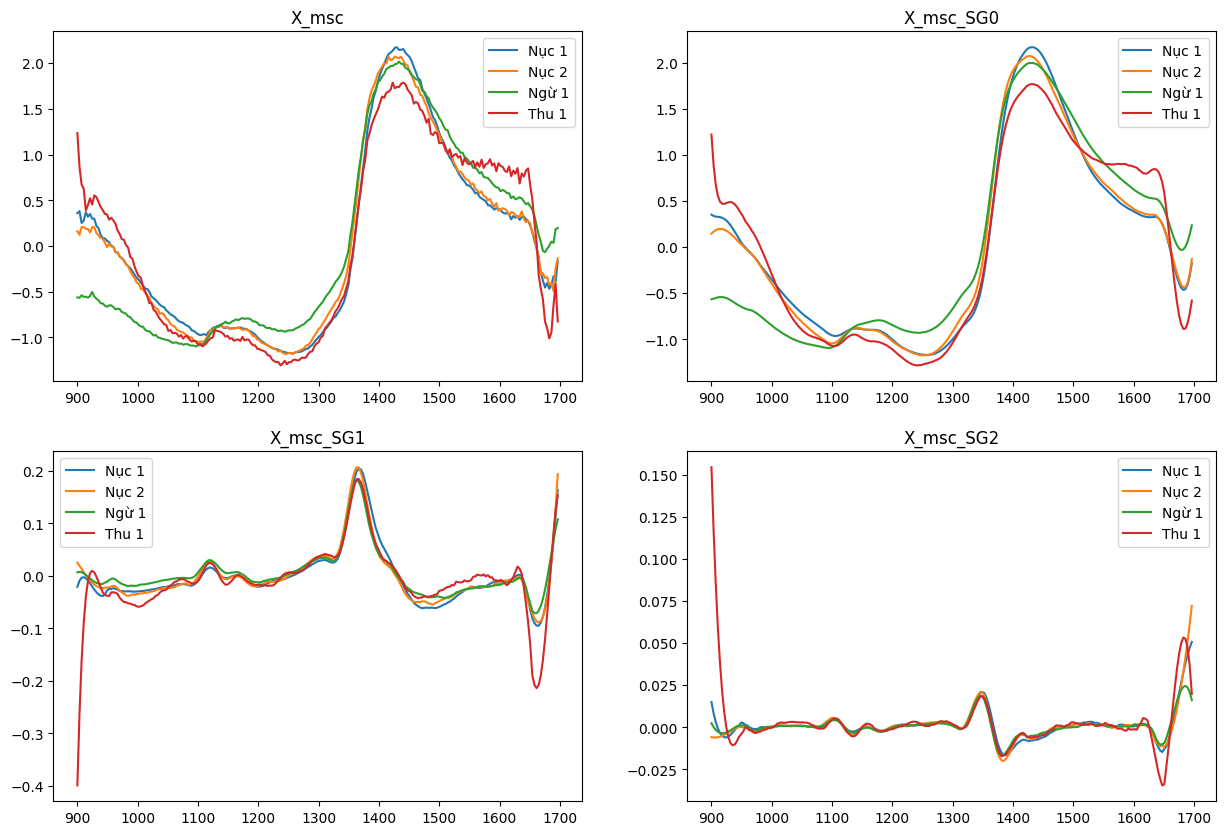

In [89]:
plot_spectral(X_msc, 'msc')

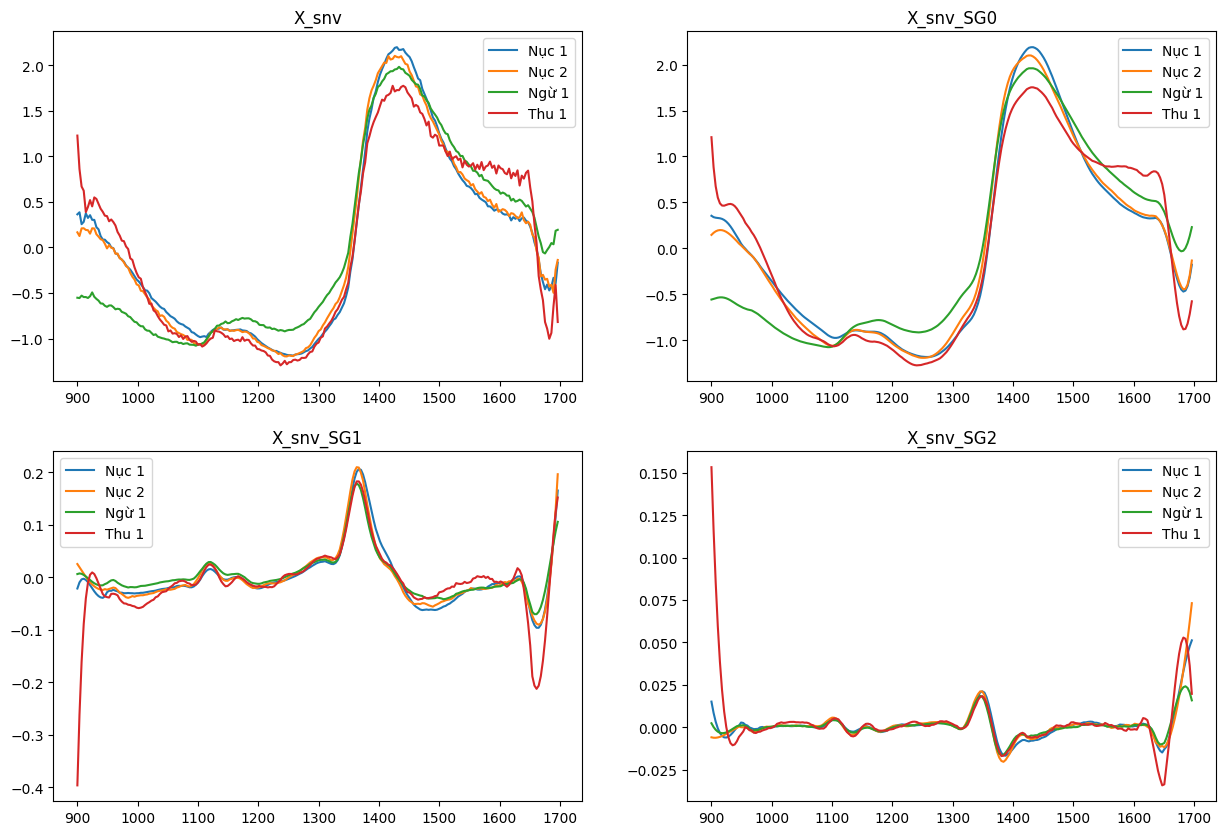

In [90]:
plot_spectral(X_snv, 'snv')

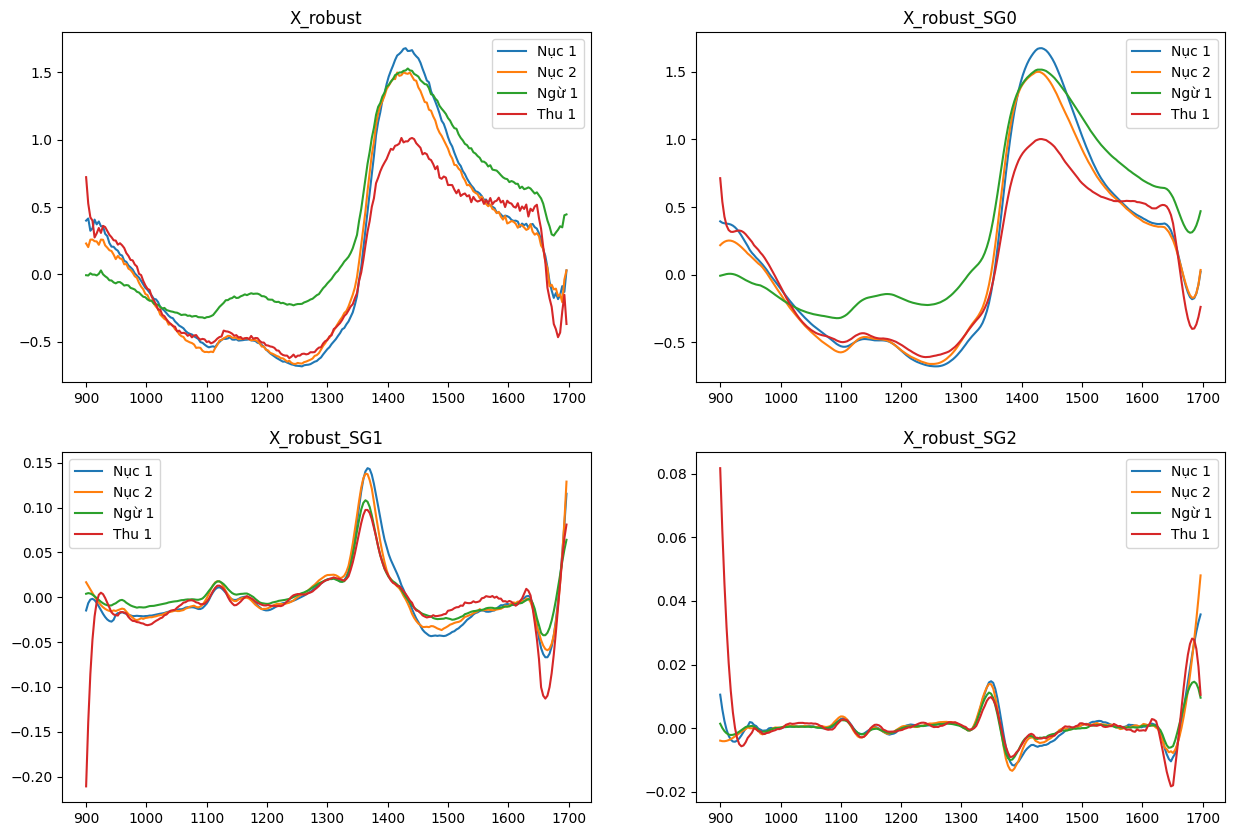

In [91]:
plot_spectral(X_Robust, 'robust')

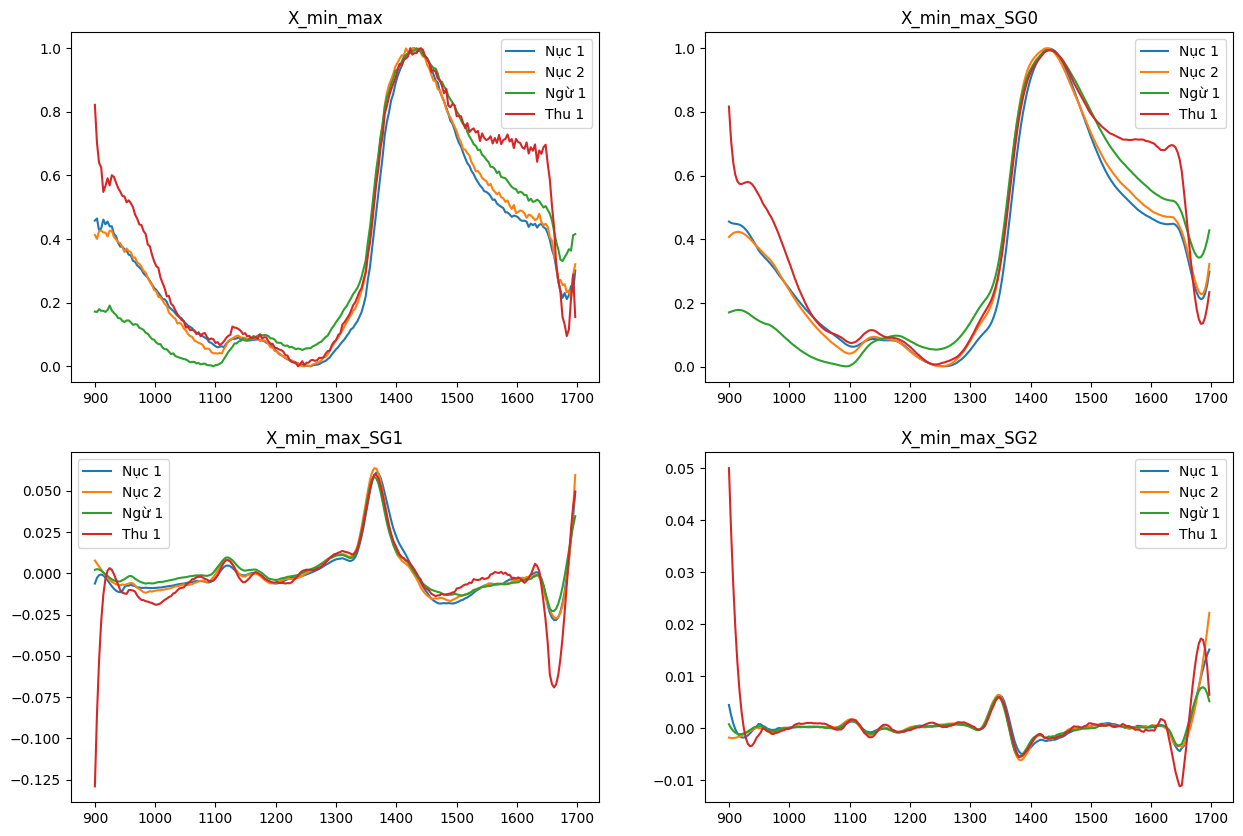

In [92]:
plot_spectral(X_minmax, 'min_max')

# KNN

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
skf = StratifiedKFold(n_splits=5)

In [114]:
acc_knn = []

xticks = np.arange(3, 30, 2)
for k in xticks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    acc_knn.append(accuracy_score(y_test, y_pred_knn))
    


Text(0.5, 1.0, 'Optimal n neighbors for KNN = 3')

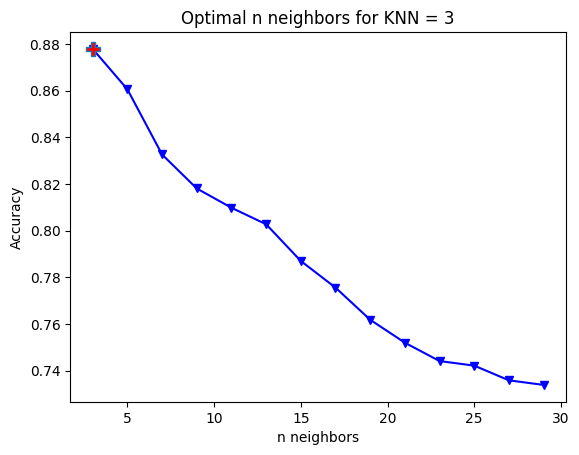

In [134]:
idx_knn = np.argmax(acc_knn)
optimal_n_neighbors = idx_knn*2 + 3

plt.plot(np.arange(3, 30, 2), acc_knn, '-v', color='blue', mfc='blue')
plt.plot(np.arange(3, 30, 2)[idx_knn], acc_knn[idx_knn], 'P', ms=10, mfc='red')
plt.xlabel("n neighbors")
plt.ylabel("Accuracy")
plt.title(f'Optimal n neighbors for KNN = {optimal_n_neighbors}')

In [117]:
def my_KNN(X_input, y_input, feature='sg0', normalization = ''):
    
    X_prep = X_input
    if normalization == 'msc':
        X_prep = msc(X_input)
    elif normalization == 'snv':
        X_prep = snv(X_input)
    elif normalization == 'minmax':
        X_prep = my_MinMaxScaler(X_input)
    elif normalization == 'robust':
        X_prep = my_RobustScaler(X_input)
        
    if feature == 'sg0':
        X_prep = my_SG(X_prep, 0)
    elif feature == 'sg1':
        X_prep = my_SG(X_prep, 1)
    elif feature == 'sg2':
        X_prep = my_SG(X_prep, 2)
    elif feature == 'sg1 + sg2':
        X_SG1 = my_SG(X_prep, 1)
        X_SG2 = my_SG(X_prep, 2)
        X_prep = np.hstack([X_SG1, X_SG2])
        
    X_train, X_test, y_train, y_test = train_test_split(X_prep, y_input,stratify=y_input, test_size = 0.2, random_state = 42)

    knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    # print(x, accuracy_score(y_pred, y_test))
    return acc


In [121]:
my_KNN(X_smote, y_smote, feature='sg0', normalization='robust')

91.024

In [ ]:
# all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
# all_normalization = ['', 'msc', 'snv', 'minmax', 'robust']
# with open('accuracy_KNN8000_URE_BALANCE.csv', 'w', newline='',encoding='utf-8-sig') as f:
#     headers = ['3', '5', '7', '9']
#     csv.DictWriter(f, delimiter=',', lineterminator='\n', fieldnames=headers).writeheader()
#     writer = csv.writer(f)
#     for feature in all_feature_exaction:
#         for normal in all_normalization:
#             writer.writerow(my_KNN(X_smote, y_smote, feature=feature, normalization=normal))


# Decision Tree

In [93]:
from sklearn.tree import DecisionTreeClassifier

In [94]:
acc_gini = []
acc_en = []
xticks = np.arange(2, 41)
for depth in xticks:
    clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    clf_gini.fit(X_train, y_train)
    y_pred_gini = clf_gini.predict(X_test)
    acc_gini.append(accuracy_score(y_test, y_pred_gini))
    
    clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    clf_en.fit(X_train, y_train)
    y_pred_en = clf_en.predict(X_test)
    acc_en.append(accuracy_score(y_test, y_pred_en))

Text(0.5, 1.0, 'Decision Tree with entropy (max_depth optimal = 40)')

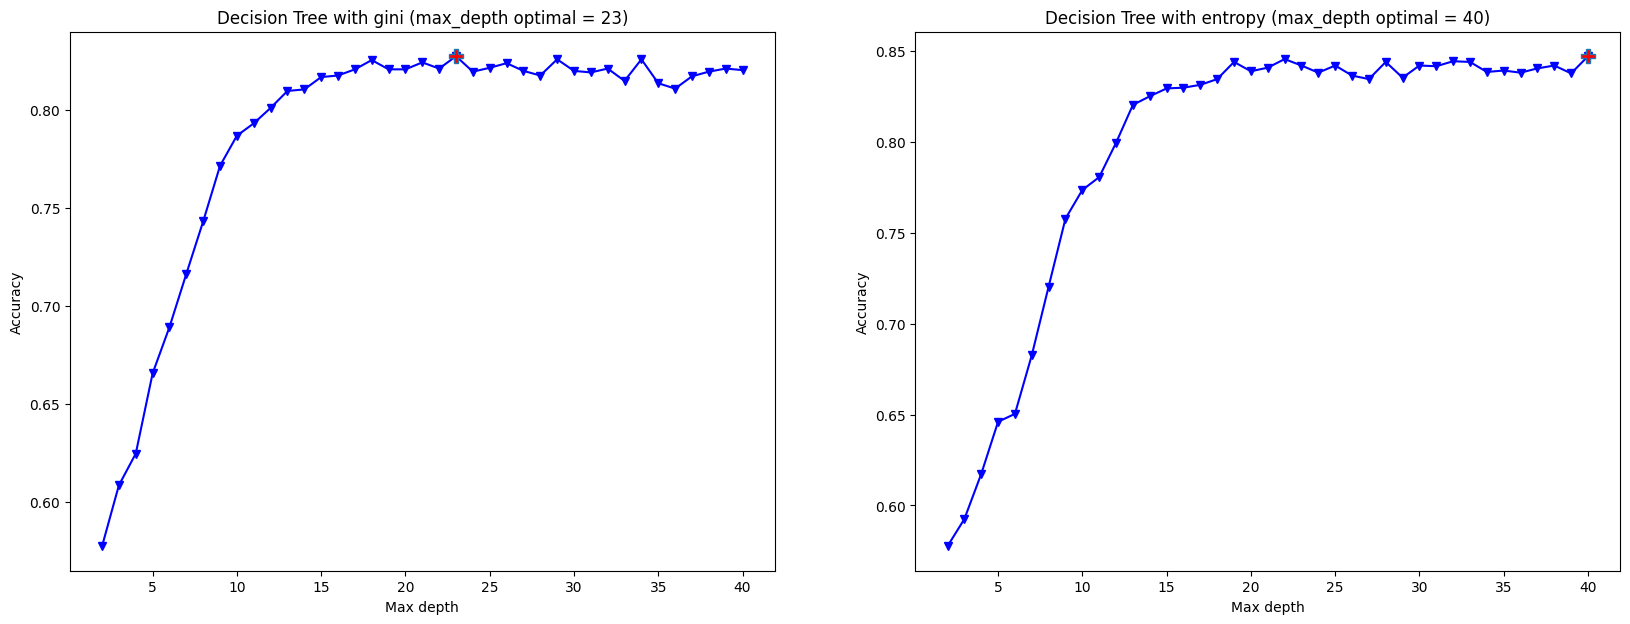

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].plot(xticks, acc_gini, '-v', color='blue', mfc='blue')
optimal_max_depth_gini = np.argmax(acc_gini) + 2
ax[0].plot(xticks[optimal_max_depth_gini - 2], acc_gini[optimal_max_depth_gini - 2], 'P', ms=10, mfc='red')
ax[0].set_xlabel("Max depth")
ax[0].set_ylabel("Accuracy")
ax[0].set_title(f'Decision Tree with gini (max_depth optimal = {optimal_max_depth_gini})')

ax[1].plot(xticks, acc_en, '-v', color='blue', mfc='blue')
optimal_max_depth_en = np.argmax(acc_en) + 2
ax[1].plot(xticks[optimal_max_depth_en - 2], acc_en[optimal_max_depth_en - 2], 'P', ms=10, mfc='red')
ax[1].set_xlabel("Max depth")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(f'Decision Tree with entropy (max_depth optimal = {optimal_max_depth_en})')

In [97]:

acc_gini2 = []
acc_en2 = []
xticks = np.arange(1, 20)
for sample in xticks:
    clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=optimal_max_depth_gini, min_samples_leaf=sample)
    clf_gini.fit(X_train, y_train)
    y_pred_gini = clf_gini.predict(X_test)
    acc_gini2.append(accuracy_score(y_test, y_pred_gini))
    
    clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_max_depth_en, min_samples_leaf=sample)
    clf_en.fit(X_train, y_train)
    y_pred_en = clf_en.predict(X_test)
    acc_en2.append(accuracy_score(y_test, y_pred_en))

Text(0.5, 1.0, 'Decision Tree with entropy (min_samples_leaf optimal = 3)')

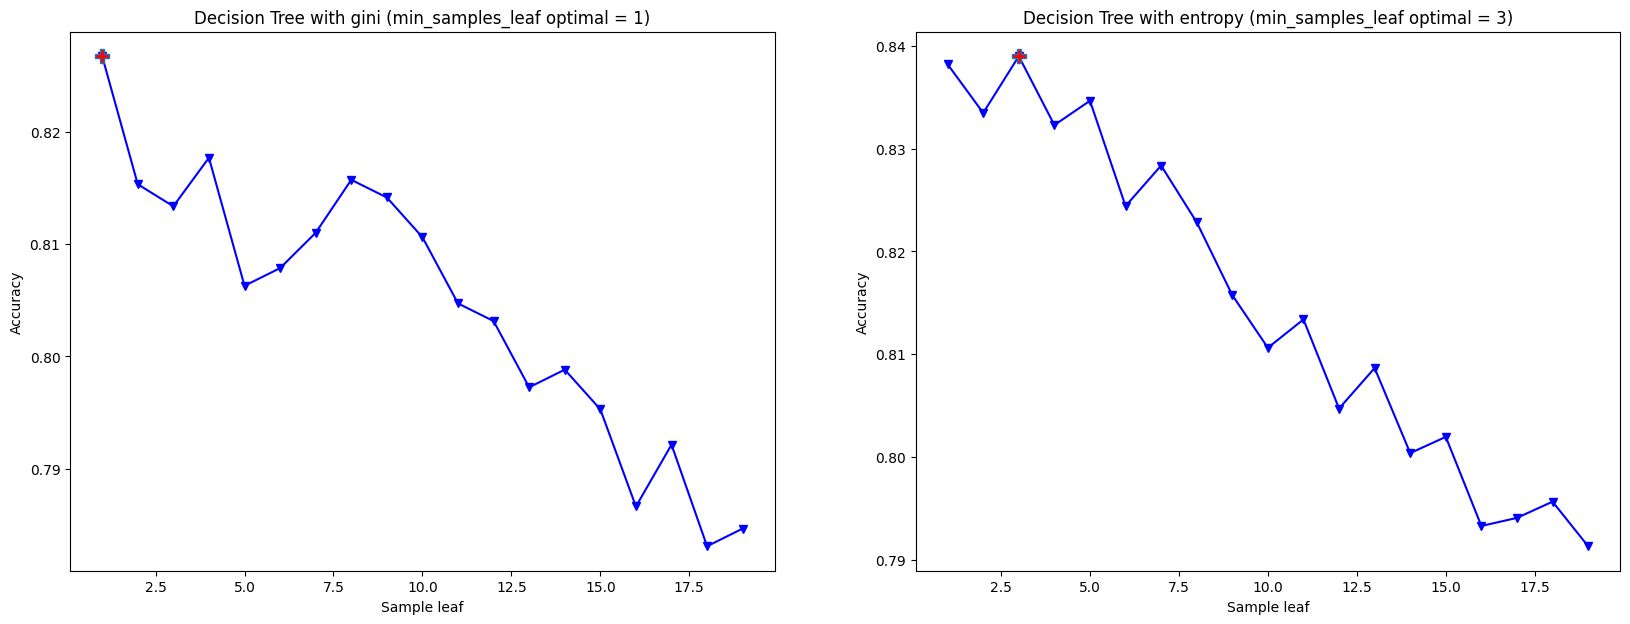

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].plot(xticks, acc_gini2, '-v', color='blue', mfc='blue')
optimal_min_samples_leaf_gini = np.argmax(acc_gini2) + 1
ax[0].plot(xticks[optimal_min_samples_leaf_gini - 1], acc_gini2[optimal_min_samples_leaf_gini - 1], 'P', ms=10, mfc='red')
ax[0].set_xlabel("Sample leaf")
ax[0].set_ylabel("Accuracy")
ax[0].set_title(f'Decision Tree with gini (min_samples_leaf optimal = {optimal_min_samples_leaf_gini})')

ax[1].plot(xticks, acc_en2, '-v', color='blue', mfc='blue')
optimal_min_samples_leaf_en = np.argmax(acc_en2) + 1
ax[1].plot(xticks[optimal_min_samples_leaf_en - 1], acc_en2[optimal_min_samples_leaf_en - 1], 'P', ms=10, mfc='red')
ax[1].set_xlabel("Sample leaf")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(f'Decision Tree with entropy (min_samples_leaf optimal = {optimal_min_samples_leaf_en})')

=> Sử dụng criterion='entropy', max_depth = 40, min_samples_leaf = 3 sẽ là tối ưu nhất

In [119]:
def my_DecisionTree(X_input, y_input, feature='sg0', normalization = ''):
    
    X_prep = X_input
    if normalization == 'msc':
        X_prep = msc(X_input)
    elif normalization == 'snv':
        X_prep = snv(X_input)
    elif normalization == 'minmax':
        X_prep = my_MinMaxScaler(X_input)
    elif normalization == 'robust':
        X_prep = my_RobustScaler(X_input)
        
    if feature == 'sg0':
        X_prep = my_SG(X_prep, 0)
    elif feature == 'sg1':
        X_prep = my_SG(X_prep, 1)
    elif feature == 'sg2':
        X_prep = my_SG(X_prep, 2)
    elif feature == 'sg1 + sg2':
        X_SG1 = my_SG(X_prep, 1)
        X_SG2 = my_SG(X_prep, 2)
        X_prep = np.hstack([X_SG1, X_SG2])
        
    X_train, X_test, y_train, y_test = train_test_split(X_prep, y_input, stratify=y_input, test_size = 0.2, random_state = 42)
 
    clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_max_depth_en, min_samples_leaf=optimal_min_samples_leaf_en)
    clf_en.fit(X_train, y_train)
    y_pred_en = clf_en.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred_en),5)*100
    
    # print(acc)
    # print("="*20)
    return acc

In [120]:
my_DecisionTree(X_smote, y_smote, feature='sg0', normalization='robust')

82.756


82.756

In [125]:
# all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
# all_normalization = ['msc', 'snv', 'minmax', 'robust']
# with open('accuracy_DecisionTree_URE_BALANCE2.csv', 'w', newline='',encoding='utf-8-sig') as f:
#     headers = ['entropy']
#     csv.DictWriter(f, delimiter=',', lineterminator='\n', fieldnames=headers).writeheader()
#     writer = csv.writer(f)
#     for feature in all_feature_exaction:
#         for normal in all_normalization:
#             writer.writerow(my_DecisionTree(X_smote, y_smote, feature=feature, normalization=normal))

# Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
acc_en = []
xticks = np.arange(100,301,10)
for n_tree in xticks:
    rfc_en = RandomForestClassifier(n_estimators=n_tree, criterion='entropy', max_depth=optimal_max_depth_en, 
                                    min_samples_leaf=optimal_min_samples_leaf_en)
    rfc_en.fit(X_train, y_train.ravel())
    y_pred_en = rfc_en.predict(X_test)
    acc_en.append(accuracy_score(y_test, y_pred_en))

Text(0.5, 1.0, 'Random forest (n tree optimal = 290)')

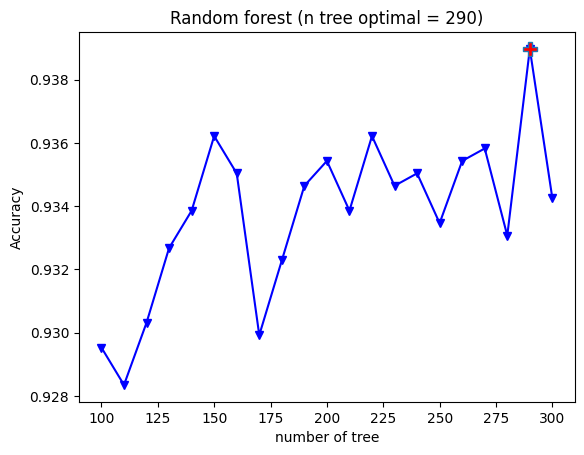

In [131]:
idx_en = np.argmax(acc_en)
optimal_n_estimators_en = idx_en*10 + 100

plt.plot(xticks, acc_en, '-v', color='blue', mfc='blue')
plt.plot(xticks[idx_en], acc_en[idx_en], 'P', ms=10, mfc='red')
plt.xlabel("number of tree")
plt.ylabel("Accuracy")
plt.title(f'Random forest (n tree optimal = {optimal_n_estimators_en})')

In [123]:

def my_RandomForest(X_input, y_input, feature='sg0', normalization = ''):
    
    X_prep = X_input
    if normalization == 'msc':
        X_prep = msc(X_input)
    elif normalization == 'snv':
        X_prep = snv(X_input)
    elif normalization == 'minmax':
        X_prep = my_MinMaxScaler(X_input)
    elif normalization == 'robust':
        X_prep = my_RobustScaler(X_input)
        
    if feature == 'sg0':
        X_prep = my_SG(X_prep, 0)
    elif feature == 'sg1':
        X_prep = my_SG(X_prep, 1)
    elif feature == 'sg2':
        X_prep = my_SG(X_prep, 2)
    elif feature == 'sg1 + sg2':
        X_SG1 = my_SG(X_prep, 1)
        X_SG2 = my_SG(X_prep, 2)
        X_prep = np.hstack([X_SG1, X_SG2])
        
    X_train, X_test, y_train, y_test = train_test_split(X_prep, y_input, stratify=y_input, test_size = 0.2, random_state = 42)

    clf_en = RandomForestClassifier(n_estimators=optimal_n_estimators_en, criterion='entropy', 
                                    max_depth=optimal_max_depth_en, min_samples_leaf=optimal_min_samples_leaf_en)
    clf_en.fit(X_train, y_train.ravel())
    y_pred_en = clf_en.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred_en),5)*100
    
    # print(acc)
    # print("="*20)
    return acc

In [ ]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']
with open('accuracy_ML_BALANCE.csv', 'w', newline='',encoding='utf-8-sig') as f:
    headers = ['KNN', 'Decision Tree', 'Random Forest']
    csv.DictWriter(f, delimiter=',', lineterminator='\n', fieldnames=headers).writeheader()
    writer = csv.writer(f)
    for feature in all_feature_exaction:
        for normal in all_normalization:
            acc = []
            acc.append(my_KNN(X_smote, y_smote, feature=feature, normalization=normal))
            acc.append(my_DecisionTree(X_smote, y_smote, feature=feature, normalization=normal))
            acc.append(my_RandomForest(X_smote, y_smote, feature=feature, normalization=normal))
            writer.writerow(acc)

# SVM

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [139]:
param = {
    'C' : [1, 10, 100, 1000],
    'kernel': ['poly', 'rbf', 'linear']
}
grid = GridSearchCV(SVC(), param, cv=4, verbose=2, refit=True)
grid.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END ...................................C=1, kernel=poly; total time=  10.9s
[CV] END ...................................C=1, kernel=poly; total time=  10.9s
[CV] END ...................................C=1, kernel=poly; total time=  11.2s
[CV] END ...................................C=1, kernel=poly; total time=  13.0s
[CV] END ....................................C=1, kernel=rbf; total time=  15.9s
[CV] END ....................................C=1, kernel=rbf; total time=  13.2s
[CV] END ....................................C=1, kernel=rbf; total time=  13.1s
[CV] END ....................................C=1, kernel=rbf; total time=  12.6s
[CV] END .................................C=1, kernel=linear; total time=  10.8s
[CV] END .................................C=1, kernel=linear; total time=  10.4s
[CV] END .................................C=1, kernel=linear; total time=  10.2s
[CV] END .................................C=1, k

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'kernel': ['poly', 'rbf', 'linear']},
             verbose=2)

In [140]:
grid.best_params_

{'C': 1000, 'kernel': 'rbf'}

In [141]:

def my_SVM(X_input, y_input, feature='sg0', normalization = ''):
    
    X_prep = X_input
    if normalization == 'msc':
        X_prep = msc(X_input)
    elif normalization == 'snv':
        X_prep = snv(X_input)
    elif normalization == 'minmax':
        X_prep = my_MinMaxScaler(X_input)
    elif normalization == 'robust':
        X_prep = my_RobustScaler(X_input)
        
    if feature == 'sg0':
        X_prep = my_SG(X_prep, 0)
    elif feature == 'sg1':
        X_prep = my_SG(X_prep, 1)
    elif feature == 'sg2':
        X_prep = my_SG(X_prep, 2)
    elif feature == 'sg1 + sg2':
        X_SG1 = my_SG(X_prep, 1)
        X_SG2 = my_SG(X_prep, 2)
        X_prep = np.hstack([X_SG1, X_SG2])
        
    X_train, X_test, y_train, y_test = train_test_split(X_prep, y_input, stratify=y_input, test_size = 0.2, random_state = 42)

    # default SVM (rbf kernel)
    svc = SVC(kernel='rbf', C=1000) 
    svc.fit(X_train, y_train.ravel())
    y_pred = svc.predict(X_test)
    acc = np.round(accuracy_score(y_test, y_pred),5)*100

    return acc

In [142]:
all_feature_exaction = ['sg0', 'sg1', 'sg2', 'sg1 + sg2']
all_normalization = ['msc', 'snv', 'minmax', 'robust']

for feature in all_feature_exaction:
    for normal in all_normalization:
        print(my_SVM(X_smote, y_smote, feature=feature, normalization=normal))

75.512
77.008
77.835
77.12599999999999
83.74000000000001
85.394
86.22
84.37
77.913
78.54299999999999
79.92099999999999
77.95299999999999
83.976
85.236
86.339
84.25200000000001
